# Instance Segmentation with Mask Region Based Convolutional Neural Network.

You should have seen in our previous posts that Convolutional Neural Network is the state of the art for any computer vision task like

- [Image classification](https://www.learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/)

- [Semantic Segmentation](https://www.learnopencv.com/pytorch-for-beginners-semantic-segmentation-using-torchvision/)


- [Object Detection](https://www.learnopencv.com/faster-r-cnn-object-detection-with-pytorch/)

In this notebook we will look at another computer vision application called Instance Segmentation. 

동일한 객체에 속하는 픽셀을 나타내는(색상 또는 그레이스케일 값 사용) 마스크가 필요하다. 이 마스크를 생성하는 알고리즘 클래스를 instance segmentation라고 한다.

instance segmentation과 semantic segmentation은 두 가지면에서 차이점이 있다.
1. semantic segmentation에서는 모든 픽셀에 클래스 라벨이 할당되지만 instance는 그렇지 않다.
2. semantic segmentation의 같은 클래스의 instance들을 구분하지 않는다. 예를 들어 semantic segmentation에서 개인 클래스에 속하는 모든 픽셀에는 마스크에서 동일한 색상/값이 할당된다. instance segmentation에서는 서로 다른 값이 할당되며 어떤 픽셀이 어떤 사람과 일치하는지 알 수 있다. 

# Instance Segmentation
  Instance Segmentation is a combination of 2 problems
  - Object Detection 이미지 내의 모든 픽셀에 클래스 라벨을 할당
  - Semantic Segmentation 객체가 포함된 경계 상자에 클래스 레이블을 할당
  
![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRmp4t9zSQ9DWyTuWv2OwK4Eq4ydaBbvl1FiaslP_y0etJ89n-5)
  
A kind of network called Mask RCNN is the state of the art in Instance Segmentation. Mask RCNN uses 2 type of networks one like Faster RCNN for Object Detection and another fully convolutional network for Semantic Segmentation. The first model will get the bounding box and classify it and the second model is used on each of the region of interest for semantic segmentation.
  
  mask RCNN이라는 네트워크의 일종으로 instance segmentation의 기술이 있다. mask RCNN은 객체 감지를 위한 faster RCNN 과 semantic segmentation을 위한 fully convolutional network 에 대한 2가지 유형의 네트워크를 사용한다. 첫 번째 모델은 bounding box를 가질 것이고 그것을 분류한다. 두번째 모델은 segmantic segmentation을 위해 각 관심 영역에 사용된다.

![](https://cdn-images-1.medium.com/max/1600/1*IWWOPIYLqqF9i_gXPmBk3g.png)
Image Source: [Mask R-CNN](https://arxiv.org/pdf/1703.06870.pdf)

mask R-CNN의 architecture은 faster R-CNN의 확장이다.

faster R-CNN의 구성
1. convolutional layers: 입력 이미지는 여러 개의 convolutional layers을 통과하여 feature map을 만든다. 3-channels 입력 이미지를 받아 공간 차원(7x7)은 훨씬 작지만 채널 수(512)는 많은 이미지를 출력하는 블랙박스라고 생각하면 된다. 
2. Region Proposal Network(RPN): convolutional layers의 출력은 사물을 둘러싸는 region proposal network를 훈련하는데 사용된다.
3. classifier: feature map은 box안의 물체에 라벨을 할당하는 classifier을 훈련하는데 사용된다.

feature map이 RPN과 calssifier에서 한번에 계산되어 사용되기 때문에 faster R-CNN이 fast R-CNN보다 더 빠르다.

mask R-CNN은 feature map을 RPN과 분류기에 공급할 뿐만 아니라 경계 상자 안에 있는 물체에 대한 마스크를 예측하는데도 사용된다.

mask R-CNN의 마스크 예측 부분을 보는 방법은 semantic segmentation에 사용되는 FCN(Fully Convolutional Network)이다. 유일한 차이점은 FCN이 경계 상자에 적용되고 convolutional layer을 RPN과 classifier에 공유시킨다는 것이다.


# Instance Segmentation in PyTorch

If you want to learn more about all of these models and many more application and concepts of Deep Learning and Computer Vision indetail,  check out the official [Deep Learning and Computer Vision courses](https://opencv.org/courses/) by OpenCV.org.

  All the pretrained models in pytorch can be found in [torchvision.models](https://pytorch.org/docs/stable/torchvision/models.html)



The input to the model is expected to be a list of tensors, each of shape [C, H, W], one for each image, and should be in 0-1 range. Different images can have different sizes.


During inference, the model requires only the input tensors, and returns the post-processed predictions as a List[Dict[Tensor]], one for each input image. The fields of the Dict are as follows:

- boxes (Tensor[N, 4]): the predicted boxes in [x0, y0, x1, y1] format, with values between 0 and H and 0 and W

- labels (Tensor[N]): the predicted labels for each image

-  scores (Tensor[N]): the scores or each prediction

-  masks (Tensor[N, H, W]): the predicted masks for each instance, in 0-1 range. In order to obtain the final segmentation masks, the soft masks can be thresholded, generally with a value of 0.5 (mask >= 0.5)

모델에서는 텐서 이미지(N, C, H, W) (N: number of image, C: number of channels - RGB의 경우 3, H: height of image, W: weight of image) 를 가진다.
모델은 경계 상자 좌표, 클래스 라벨과 라벨 점수, 라벨에 있는 각 반의 마스크를 반환할 것이다.

In [8]:
# import necessary libraries
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2
import random
import time
import os



 # These are the classes that are available in the COCO-Dataset
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]



## Download the model

In [9]:
# get the pretrained model from torchvision.models
# Note: pretrained=True will get the pretrained weights for the model.
# model.eval() to use the model for inference
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

Let's create some helper functions.   
We will create the `random_colour_masks()` function to fill the predicted-mask with colors, `get_predictions()` to return the final predictions from the model and finally the `instance_segmentation_api()` to overlay the colored mask over the original image and plot it.

In [10]:
def random_colour_masks(image):
    """
    random_colour_masks
    parameters:
      - image - predicted masks
    method:
      - the masks of each predicted object is given random colour for visualization
    """
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)] # randrange - 범위 중 하나를 무작위로 얻는다.
    coloured_mask = np.stack([r, g, b], axis=2) # rgb를 2차원적으로 병합
    return coloured_mask

def get_prediction(img_path, threshold):
    """
    get_prediction
    parameters:
      - img_path - path of the input image
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
        ie: eg. segment of cat is made 1 and rest of the image is made 0

    """
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class


def instance_segmentation_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
    """
    instance_segmentation_api
    parameters:
      - img_path - path to input image
    method:
      - prediction is obtained by get_prediction
      - each mask is given random color
      - each mask is added to the image in the ration 1:0.8 with opencv
      - final output is displayed
    """
    masks, boxes, pred_cls = get_prediction(img_path, threshold)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
        rgb_mask = random_colour_masks(masks[i])
        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0) # addweighted(첫번째 영상, 첫번째 영상 가중치, 두번째 영상(첫번째와 같은 크기나 같은 타입), 두번째 영상 가중치, 결과 영상에 추가적으로 더할 값, 가중치 합 결과 영상, 츨력 영상 타입)
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # 경계 박스 그리기
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

## Running inference on an image

--2021-07-27 08:51:59--  https://cdn.pixabay.com/photo/2015/09/02/13/24/girl-919048_1280.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.20.183, 104.18.21.183, 2606:4700::6812:15b7, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.20.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96982 (95K) [image/jpeg]
Saving to: ‘person.jpg’

person.jpg          100%[===================>]  94.71K  --.-KB/s    in 0.007s  

2021-07-27 08:51:59 (13.0 MB/s) - ‘person.jpg’ saved [96982/96982]



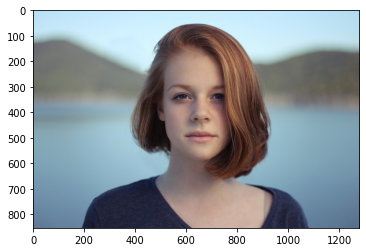

In [11]:
# Download the image and plotting it
!wget "https://cdn.pixabay.com/photo/2015/09/02/13/24/girl-919048_1280.jpg" -O person.jpg

img = Image.open('./person.jpg')
plt.imshow(img)
plt.show()

In [12]:
# Running inference on the image
transform = T.Compose([T.ToTensor()])
img_tensor = transform(img)
pred = model([img_tensor])

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [13]:
# Lets look at what the `pred` looks like.
# `pred` is a list of dictionaries, since we had passed a single image, we will get a single-item list
pred[0]

{'boxes': tensor([[ 163.7835,   57.6295, 1090.9226,  850.5343],
         [  23.1606,   15.2324, 1271.7826,  203.9946]], grad_fn=<StackBackward>),
 'labels': tensor([ 1, 28]),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]], grad_fn=<UnsqueezeBackward0>),
 'scores': tensor([0.9995, 0.0638], grad_fn=<IndexBackward>)}

In [14]:
# We will keep only the pixels with values  greater than 0.5 as 1, and set the rest to 0.
masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
masks[0]
# print(masks, '\n',masks.shape) # (2개의 값, 1개의 [] 안에 853행 1280열)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

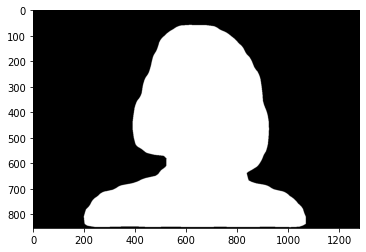

In [15]:
# Let's plot the mask for the `person` class since the 0th mask belongs to `person`
plt.imshow(masks[0], cmap='gray') # 사람과 배경의 분류 확인
plt.show()

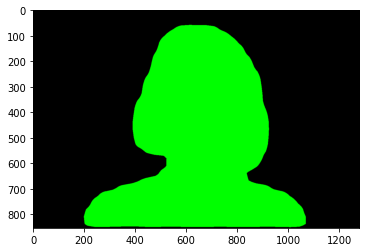

In [16]:
# Let's color the `person` mask using the `random_colour_masks` function
mask1 = random_colour_masks(masks[0])
plt.imshow(mask1)
plt.show()

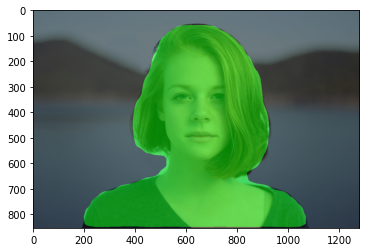

In [17]:
# Let's blend the original and the masked image and plot it.
blend_img = cv2.addWeighted(np.asarray(img), 0.5, mask1, 0.5, 0)

plt.imshow(blend_img)
plt.show()

In [18]:
!wget -nv https://www.wsha.org/wp-content/uploads/banner-diverse-group-of-people-2.jpg -O mrcnn_standing_people.jpg
img = Image.open('./mrcnn_standing_people.jpg')
transform = T.Compose([T.ToTensor()]) ; img_tensor = transform(img) ; pred = model([img_tensor])
pred[0]

2021-07-27 08:52:10 URL:https://www.wsha.org/wp-content/uploads/banner-diverse-group-of-people-2.jpg [1923610/1923610] -> "mrcnn_standing_people.jpg" [1]


{'boxes': tensor([[1141.6859,  417.8743, 1574.5472, 1316.7277],
         [ 763.2020,  349.9328, 1183.3583, 1318.4663],
         [   0.0000,  333.4453,  445.7028, 1308.1669],
         [1508.0762,  445.6717, 1998.9941, 1321.7173],
         [ 356.7939,  354.4644,  761.7194, 1317.8088],
         [ 619.0010,  283.9809,  926.9828, 1286.6600],
         [1444.6964,  332.3297, 1666.1591,  791.6866],
         [1156.3657,  176.2211, 1446.0736,  690.2692],
         [1708.0619,  284.0534, 2000.0000,  900.2240],
         [1599.7603,  193.7901, 1760.9299,  606.6691],
         [ 542.5824,  239.4967,  716.8364,  564.5811],
         [ 884.7247,  191.7781, 1233.9467,  753.4769],
         [ 236.4741,  109.0884,  479.7087,  675.6945],
         [ 209.5420,  248.1480,  639.4666, 1323.4458],
         [ 816.3386,  190.7328, 1132.5623,  617.8146],
         [   8.9963, 1139.4198,  155.2516, 1329.5149],
         [ 163.2869,  594.8453,  401.4730,  945.3849],
         [ 944.0461,  294.6652, 1371.6185, 1298.2878],
 

In [ ]:
!wget -nv https://www.wsha.org/wp-content/uploads/banner-diverse-group-of-people-2.jpg -O mrcnn_standing_people.jpg
instance_segmentation_api('./mrcnn_standing_people.jpg', 0.75) # threshold는 물체를 인식하는 정도, 즉 판별 임계값, 높을수록 좋은 것은 아니다.

In [ ]:
!wget https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/10best-cars-group-cropped-1542126037.jpg -O mrcnn_cars.jpg
instance_segmentation_api('./mrcnn_cars.jpg', 0.9, rect_th=5, text_size=5, text_th=5)

In [ ]:
!wget https://cdn.pixabay.com/photo/2013/07/05/01/08/traffic-143391_960_720.jpg -O mrcnn_traffic.jpg
instance_segmentation_api('./mrcnn_traffic.jpg', 0.6, rect_th=2, text_size=1, text_th=2)

In [ ]:
!wget https://cff2.earth.com/uploads/2019/04/18174234/Why-do-some-animals-eat-their-young--730x410.jpg -O mrcnn_birds.jpg
instance_segmentation_api('./mrcnn_birds.jpg', 0.9)  

In [ ]:
!wget http://s1.favim.com/orig/24/boy-pandora-people-street-Favim.com-218622.jpg -O mrcnn_people.jpg
instance_segmentation_api('./mrcnn_people.jpg', 0.8, rect_th=1, text_size=1, text_th=1)    

In [ ]:
!wget -nv https://images.unsplash.com/photo-1475505035646-a4680971b0fb -O mrcnn_playing.jpg
instance_segmentation_api('./mrcnn_playing.jpg', 0.8, rect_th=6, text_size=6, text_th=6)    

In [ ]:
!wget https://images.unsplash.com/photo-1509205477838-a534e43a849f -O mrcnn_cat_dog.jpg
instance_segmentation_api('./mrcnn_cat_dog.jpg', 0.95, rect_th=5, text_size=5, text_th=5)    

In [ ]:
!wget https://cdn-image.travelandleisure.com/sites/default/files/1556203941/katmai-alaska-bears-AKBEAR0419.jpg -O mrcnn_bear.jpg
instance_segmentation_api('./mrcnn_bear.jpg', 0.9, rect_th=6, text_size=5, text_th=5)    

In [ ]:
!wget https://images.unsplash.com/photo-1505148230895-d9a785a555fa -O mrcnn_elephants.jpg
instance_segmentation_api('./mrcnn_elephants.jpg', 0.9, rect_th=6, text_size=6, text_th=6)    

In [ ]:
!wget https://images.unsplash.com/photo-1543205764-fee67cf76589 -O mrcnn_baby_teddy.jpg
instance_segmentation_api('./mrcnn_baby_teddy.jpg', 0.95, rect_th=6, text_size=6, text_th=6)    

# Comparing the inference time of model in CPU & GPU



In [29]:

def check_inference_time(image_path, gpu=False):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    model.eval()
    img = Image.open(image_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    if gpu:
        model.cuda()
        img = img.cuda()
    else:
        model.cpu()
        img = img.cpu()
    start_time = time.time()
    pred = model([img])
    end_time = time.time()
    return end_time-start_time

In [30]:
# Let's run inference on all the downloaded images and average their inference time 
img_paths = [path for path in os.listdir(".") if path.split(".")[-1].lower() in ["jpeg", "jpg", "png"] ]

gpu_time = sum([check_inference_time(img_path, gpu=True) for img_path in img_paths])/len(img_paths)
cpu_time = sum([check_inference_time(img_path, gpu=False) for img_path in img_paths])/len(img_paths)

print('\n\nAverage Time take by the model with GPU = {}s\nAverage Time take by the model with CPU = {}s'.format(gpu_time, cpu_time))



Average Time take by the model with GPU = 0.4173847111788663s
Average Time take by the model with CPU = 9.021545952016657s


# Application: Background blurring

Here we will use the segmentation algorithm to blur the background. The whole concept is broken down into few steps.  
1. Pick the class we want to keep as foreground (person) and get its mask using the segmentation api. The locations belonging to person-class will be labelled as 1 and the rest as 0.
2. Blur the original image.
3. Create a new image such that, pixel locations where the mask is 1 is replaced with the original values and the rest with the blurred values.

Following is the code.

segmentation 알고리즘을 사용하여 배경을 blur 처리할 것이다. 전체 개념은 세 단계로 나뉘어진다.
1. 보관할 클래스의 foreground로 선택하고 segmentation api를 사용하여 마스크를 가져온다. person-class에 속하는 위치는 1로 표시하고 나머지는 0으로 표시한다.
2. 이미지를 흐리게 한다.
3. 마스크가 1인 픽셀 위치가 원래 값으로 대체되고 나머지는 흐린 값으로 대체되도록 새 이미지를 만든다.

In [51]:
def pick_person_mask(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
    # get the predicted masks and boxes and their corresponding labels
    masks, boxes, pred_cls = get_prediction(img_path, threshold)
    # pick the indices belonging to person
    person_ids = [i for i in range(len(pred_cls)) if pred_cls[i]=="person"]
    # pick the masks with the person-ids
    person_masks = masks[person_ids, :, :]
    # create a single mask out of all the instances and clip them
    persons_mask = person_masks.sum(axis=0)
    persons_mask = np.clip(persons_mask, 0,1) # 0보다는 작은 값들을 0으로, 1보다 큰값들을 1로 바꿔주는 함수
    print(persons_mask)
    return persons_mask 

2021-07-27 09:09:46 URL:https://cdn.pixabay.com/photo/2017/02/06/10/54/sad-2042536_1280.jpg [260652/260652] -> "person_blur.jpg" [1]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


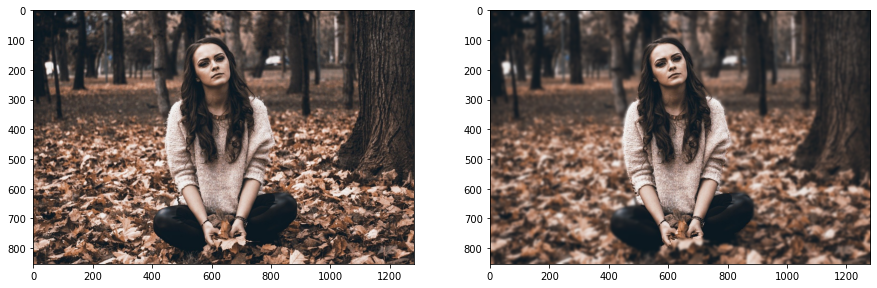

In [53]:
# These are a few images you can play around with

# https://cdn.pixabay.com/photo/2016/02/19/10/06/woman-1209072_1280.jpg
# https://cdn.pixabay.com/photo/2018/03/12/20/57/woman-3220835_1280.jpg
# https://cdn.pixabay.com/photo/2017/02/06/10/54/sad-2042536_1280.jpg
# https://cdn.pixabay.com/photo/2016/11/29/09/49/blond-1868815_1280.jpg
# https://cdn.pixabay.com/photo/2017/03/27/14/56/auto-2179220_1280.jpg
# https://cdn.pixabay.com/photo/2017/03/27/14/56/auto-2179220_1280.jpg

!wget -nv https://cdn.pixabay.com/photo/2017/02/06/10/54/sad-2042536_1280.jpg -O person_blur.jpg

# grab the image and blur it
img_path = "person_blur.jpg"
img = cv2.imread(img_path)
img_blur = cv2.GaussianBlur(img, (21, 21), 0)

# create the person-mask
person_mask = pick_person_mask(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3).astype(np.uint8)
person_mask = np.repeat(person_mask[:, :, None], 3, axis=2) # person_mask를 3번째 축을 따라 세 번 반복

# finally, create a new image such that pixels where the mask=1, replace it with original image and keep the rest of the pixels
# with blurred image
final_img = np.where(person_mask==1, img, img_blur) # where은 조건문을 사용할 때 사용, 1인 값을 찾아 blur 로 바꾼다.

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(img[:,:,::-1])
plt.subplot(122)
plt.imshow(final_img[:,:,::-1])
plt.show()